In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pympc.models.boxatlas_parametric import BoxAtlas, MovingLimb, FixedLimb
from pympc.dynamical_systems import dare, moas_closed_loop
from pympc.control import MPCHybridController
from pympc.geometry.polytope import Polytope
import pympc.plot as mpc_plt
import director.viewerclient as vc
from director.thirdparty import transformations

Numeric parameters

In [3]:
parameters = {
    'mass': 1.,
    'stiffness': 100.,
    'damping': 1000.,
    'friction_coefficient': .5,
    'gravity': 10.,
    'sampling_time': .1
    }

Nominal state and input

In [4]:
weight = parameters['mass'] * parameters['gravity']
penetration = weight / parameters['stiffness']
nominal_limb_positions = {
    'lf': np.array([[.2], [-.5 - penetration / 2.]]),
    'rf': np.array([[-.2], [-.5 - penetration / 2.]]),
    'lh': np.array([[.3], [.0]]),
    'rh': np.array([[-.3], [.0]])
    }
nominal_limb_forces = {
    'lf': np.array([[weight / 2.], [0.]]),
    'rf': np.array([[weight / 2.], [0.]]),
    'lh': np.zeros((2,1)),
    'rh': np.zeros((2,1))
    }

State limits

In [5]:
kinematic_limits = {
        'b': {'min': np.array([[-.2],[-.1]]), 'max': np.array([[.2],[.1]])},
        'lf': {'min': np.array([[.0],[-.7]]), 'max': np.array([[.4],[-.3]])}, # wrt body
        'rf': {'min': np.array([[-.4],[-.7]]), 'max': np.array([[0.],[-.3]])}, # wrt body
        'lh': {'min': np.array([[.2],[-.2]]), 'max': np.array([[.5],[.2]])}, # wrt body
        'rh': {'min': np.array([[-.5],[-.2]]), 'max': np.array([[-.2],[.2]])}, # wrt body
        }
velocity_limits = {
        'b': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'lf': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'rf': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'lh': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        'rh': {'min': -np.ones((2,1)), 'max': np.ones((2,1))},
        }

Force limits

In [6]:
f_min = np.array([[0.], [-parameters['friction_coefficient'] * weight]])
f_max = np.array([[weight], [parameters['friction_coefficient'] * weight]])
force_limits = {
        'lf': {'min': f_min*2., 'max': f_max*2.},
        'rf': {'min': f_min*2., 'max': f_max*2.},
        'lh': {'min': f_min, 'max': f_max},
        'rh': {'min': f_min, 'max': f_max},
        }

Robot topology

In [7]:
lh = [
    MovingLimb(np.array([[1., 0.],[0., -1.]]), np.ones((2,1))/2., None),
    MovingLimb(np.array([[-1., 0.],[1., 0.],[0., -1.]]), np.array([[-.5],[.5+penetration],[.5]]), 0)
    ]
# convex house
#rh = [
#    MovingLimb(np.array([[0., -1.],[-3., -1.],[-3., 1.]]), np.array([[.5],[1.5],[1.5]]), None),
#    MovingLimb(np.array([[0., -1.],[0., 1.],[3., 1.],[-3., -1.]]), np.array([[.5],[0.],[-1.5],[1.5+penetration*np.sqrt(10)]]), 2),
#    MovingLimb(np.array([[0., -1.],[3., -1.],[-3., 1.]]), np.array([[0.],[-1.5],[1.5+penetration*np.sqrt(10)]]), 1),
#]
# wall and table
rh = [
    MovingLimb(-np.eye(2), np.array([[.35],[.5]]), None), # center
    MovingLimb(np.array([[1., 0.],[0., -1.]]), np.array([[-.35],[.1]]), None), # over the table
    MovingLimb(np.array([[0., 1.],[0., -1.],[1., 0.]]), np.array([[-.1],[.1 + penetration],[-.35]]), 0), # top of the table
    MovingLimb(np.array([[1., 0.],[-1., 0.],[0., 1.]]), np.array([[-.35],[.35 + penetration],[-.1 - penetration]]), 0) # side of the table
]


lf = FixedLimb(np.array([[.2],[-.5]]), np.array([[0.],[1.]]))
rf = FixedLimb(np.array([[-.2],[-.5]]), np.array([[0.],[1.]]))
topology = { 'moving': {'lh': lh, 'rh': rh}, 'fixed': {'lf': lf, 'rf': rf} }

Construct box atlas

In [8]:
box_atlas = BoxAtlas(
    topology,
    parameters,
    nominal_limb_positions,
    nominal_limb_forces,
    kinematic_limits,
    velocity_limits,
    force_limits
)

In [9]:
print box_atlas.contact_modes
box_atlas.print_state()
box_atlas.print_input()

[{'rh': 0, 'lh': 0}, {'rh': 0, 'lh': 1}, {'rh': 1, 'lh': 0}, {'rh': 1, 'lh': 1}, {'rh': 2, 'lh': 0}, {'rh': 2, 'lh': 1}, {'rh': 3, 'lh': 0}, {'rh': 3, 'lh': 1}]
['q_rh_x', 'q_rh_y', 'q_lh_x', 'q_lh_y', 'q_b_x', 'q_b_y', 'v_b_x', 'v_b_x']
['v_rh_x', 'v_rh_y', 'v_lh_x', 'v_lh_y', 'f_lf_n', 'f_lf_t', 'f_rf_n', 'f_rf_t']


Hybrid controller

In [10]:
N = 10
Q = box_atlas.penalize_relative_positions(np.eye(box_atlas.n_x))
R = np.eye(box_atlas.n_u)
objective_norm = 'two'
terminal_mode = 0
P, K = dare(
    box_atlas.affine_systems[terminal_mode].A,
    box_atlas.affine_systems[terminal_mode].B,
    Q,
    R)
X_N = moas_closed_loop(
    box_atlas.affine_systems[terminal_mode].A,
    box_atlas.affine_systems[terminal_mode].B,
    K,
    box_atlas.domains[terminal_mode])
#X_N = Polytope.from_bounds(-np.ones((8,1))/1000., np.ones((8,1))/1000.)
#X_N.assemble()

Computation of MOAS started... MOAS found.
MOAS facets are 323, removing redundant ones... redundant factes removed, MOAS facets are 100.


Hybrid controller

In [11]:
controller = MPCHybridController(box_atlas.pwa_system, N, objective_norm, Q, R, P, X_N)

Closed-loop system simulation

Time step 0: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 2.44683376591e-15
Time step 1: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 2.47321807978e-15
Time step 2: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 2.39428291244e-15
Time step 3: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 2.68392837303e-15
Time step 4: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 2.97734547686e-15
Time step 5: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 3.42257205057e-15
Time step 6: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 3.56644296579e-15
Time step 7: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 3.74776076984e-15
Time step 8: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 4.00874740442e-15
Time step 9: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 4.21351441315e-15
Time step 10: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
Planner-simulator missmatch: 4.424

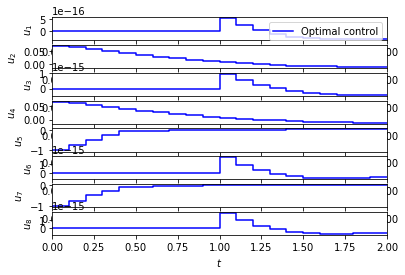

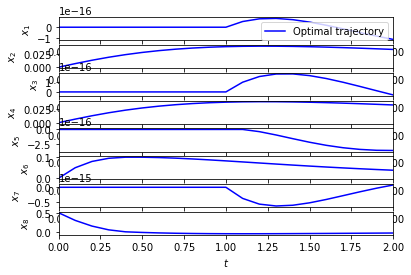

In [12]:
N_sim = 20
x_0 = np.array([
    [.0],
    [.0],
    [.0],
    [.0],
    [.0],
    [.0],
    [0.], # v_b_x
    [.5] # v_b_y
])
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
for k in range(N_sim):
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    print('Time step ' + str(k) + ': ' + str(ss_k) + '.\r')#,
    #print x_k[1]
    x_next = box_atlas.pwa_system.simulate(x[k], [u_k[0]])[0][1]
    print 'Planner-simulator missmatch:', np.linalg.norm(x_next - x_k[1])
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [box_atlas.pwa_system.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)
mpc_plt.input_sequence(u, parameters['sampling_time'])
plt.show()
mpc_plt.state_trajectory(x, parameters['sampling_time'])
plt.show()

# Visualizer

Visualizer object

In [ ]:
vis = vc.Visualizer()['box_altas']
vertical_translation = - (nominal_limb_positions['lf'][1,0] + nominal_limb_positions['rf'][1,0]) / 2.
vis.settransform(vc.transformations.translation_matrix([0.,0.,vertical_translation]))

Numeric parameters

In [ ]:
visualizer_parameters = {
    'wall_x': 1.,
    'wall_y': .02,
    'body_xyz': .2,
    'body_color': np.array([0.,0.,1.]),
    'limb_color': np.array([1.,0.,0.]),
    'wall_color': np.array([0.,1.,0.])
}

Body

In [ ]:
vis['bq'].setgeometry(
    vc.GeometryData(
        vc.Box(
            lengths = [visualizer_parameters['body_xyz']]*3),
            color = np.hstack((visualizer_parameters['body_color'], 1.))
            )
    )

Limbs

In [ ]:
for limb in ['lf', 'rf', 'lh', 'rh']:
    vis[limb].setgeometry(
        vc.GeometryData(
            vc.Sphere(radius = .05),
            color = np.hstack((visualizer_parameters['limb_color'], 1.))
            )
        )

Environment

In [ ]:
vis = box_atlas.visualize_environment(vis)

Animation

In [ ]:
box_atlas.visualize(vis, x[0])
time.sleep(10 * parameters['sampling_time'])
for k in range(N_sim):
    box_atlas.visualize(vis, x[k])
    time.sleep(parameters['sampling_time'])

# Library

In [ ]:
from pympc.control import FeasibleSetLibrary

In [ ]:
# sample filter
state_domains = box_atlas._domains()[0]

In [ ]:
# initialization of the library
library = FeasibleSetLibrary(controller)

# load
samples_so_far = 50000
library = np.load('library_box_atlas_' + str(samples_so_far) + '.npy').item()

In [ ]:
# coverage
sample_step = 500
n_steps = 10
for i in range(n_steps):
    n = samples_so_far + (i+1)*sample_step
    library.sample_policy(sample_step, state_domains)
    print(str(n) + ' samples added to the library.')
    np.save('library_box_atlas_' + str(n), library)

In [ ]:
# shifted switching sequences
library.add_shifted_switching_sequences(terminal_mode)

# Tuning

X = box_atlas._state_constraints()
X.assemble()
library = FeasibleSetLibrary(controller)
for i in range(100):
    x = library.random_sample(state_domains)
    box_atlas.visualize(vis, x)
    time.sleep(.3)

# Test library

In [ ]:
N_sim = 20
x_0 = np.array([
    [.0],
    [.1],
    [.0],
    [.0],
    [.0],
    [.0],
    [-.9], # v_b_x
    [.0] # v_b_y
])
u = []
x = [x_0]
ss = []
ss_feasible = None
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u_k, ss_k = library.feedback(x[k], ss_feasible)
    print ss_k
    u.append(u_k)
    x.append(box_atlas.pwa_system.simulate(x[k], [u_k])[0][1])
    ss.append(ss_k)
    ss_feasible = ss_k[1:] + (terminal_mode,)

In [ ]:
box_atlas